<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/ToyGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Toy dataset

# Mount to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander


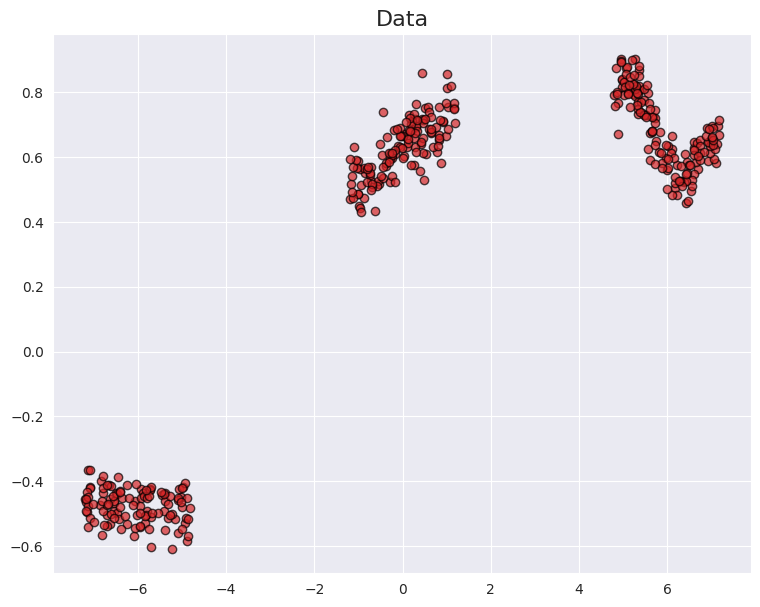

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander
----------------------------------------------------------
ALL MODELS: 
KISS-GP For 1D-4D data:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.ConstantMean()
      kernel = gpytorch.kernels.RBFKernel()
      model = KISSGP(x_train, y_train, likelihood, mean, kernel)
      model = model.to(device) # Move model to device

KISS-GP For higher dimensional data:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.ConstantMean()
      kernel = gpytorch.kernels.RBFKernel()
      model = KISSGP_NDim(x_train, y_train, likelihood, mean, kernel)
      model = model.to(device) # Move model to device

Inducing Points GP:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.Co

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch > \dev\null # Suppress prints
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import jax
import jax.numpy as jnp
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "datasets/toy.ipynb" # Run the Toy notebook
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook

# Training Data from Toy

In [201]:
x_toy , y_toy = x, y # x, y are defined in ../datasets/Toy.ipynb
x_train_toy, x_test_toy, y_train_toy, y_test_toy = train_test_split(x_toy, y_toy, test_size=0.2, random_state=666)
# Transform into tensors
x_train_toy, x_test_toy, y_train_toy, y_test_toy = (
torch.from_numpy(x_train_toy), torch.from_numpy(x_test_toy),
torch.from_numpy(y_train_toy), torch.from_numpy(y_test_toy))

# Define the KISS-GP model

In [202]:
KISSGP_likelihood_toy = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_toy = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_toy = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_toy = KISSGP(x_train_toy, y_train_toy, KISSGP_likelihood_toy, KISSGP_mean_toy, KISSGP_kernel_toy) # KISSGP defined in utils/Models.ipynb

# Train the KISS-GP Model

In [203]:
train(KISSGP_model_toy, KISSGP_likelihood_toy, x_train_toy, y_train_toy, training_iter= 40) # train is defined in utils/functions.ipynb

# Predict with KISS-GP Model

In [204]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_toy = predict(KISSGP_model_toy, KISSGP_likelihood_toy, x_test_toy) # predict is defined in utils/functions.ipynb

# Evaluate Predictions

In [205]:
# Root Mean Square Error(RMSE)
RMSE_KISSGP_toy = mean_squared_error(y_test_toy, predictions_KISSGP_toy.mean, squared=False)
RMSE_KISSGP_toy

0.06443032417243247

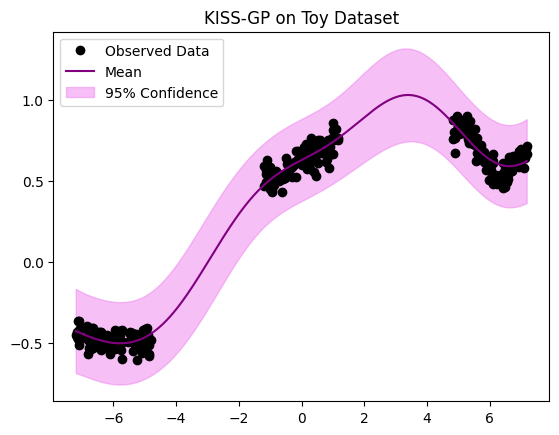

In [206]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_toy, y_train_toy, KISSGP_model_toy, KISSGP_likelihood_toy, "KISS-GP on Toy Dataset")

# Inducing Points Model -------------------------------------------------------

In [207]:
inducing_likelihood_toy = gpytorch.likelihoods.GaussianLikelihood()
inducing_mean_toy = gpytorch.means.ConstantMean()
inducing_kernel_toy = gpytorch.kernels.RBFKernel()
n_inducing_points = 150
inducing_points = x_train_toy[torch.randperm(x_train_toy.size(0))[:n_inducing_points]]
inducing_model_toy = InducingGP(inducing_likelihood_toy, inducing_mean_toy, inducing_kernel_toy, inducing_points) # InducingGP defined in utils/models.ipynb
inducing_model_toy = inducing_model_toy.to(device) # Move model to device, defined in utils/models.ipynb

# Train the inducing point model

In [208]:
train_ELBO(inducing_model_toy, inducing_likelihood_toy, x_train_toy, y_train_toy, training_iter= 60) # train is defined in utils/functions.ipynb

# Predict With Inducing Model

In [209]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_toy = predict(inducing_model_toy, inducing_likelihood_toy, x_test_toy) # predict is defined in utils/functions.ipynb

# Evaluate Predictions

In [210]:
# Root Mean Square Error(RMSE)
RMSE_inducing_toy = mean_squared_error(y_test_toy, predictions_inducing_toy.mean, squared=False)
RMSE_inducing_toy

0.07023711839176104

# Plot inducing Model

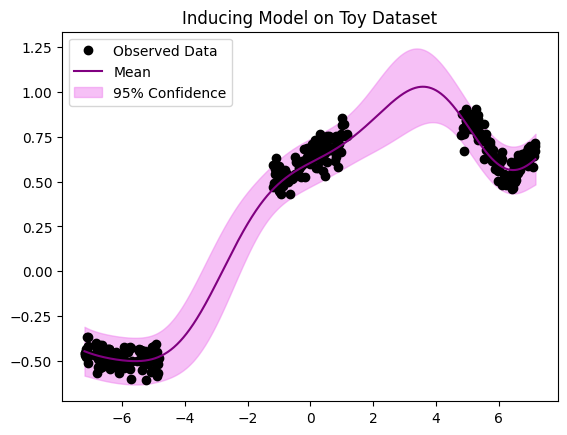

In [211]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_toy, y_train_toy, inducing_model_toy, inducing_likelihood_toy, "Inducing Model on Toy Dataset")

# State Space Model

In [212]:
# To do the regression in state space, we need to rearrange the datapoints in temporal order
n_test_points = len(x_test_toy)
all_points = jnp.concatenate([x_train_toy.numpy(), x_test_toy.numpy()])
temporal_order = jnp.argsort(all_points)

# State Space X's and Y's
ss_xs = all_points[temporal_order]
ss_ys = jnp.concatenate([y_train_toy.numpy(), jnp.nan * jnp.ones((n_test_points, ))])[temporal_order]


# Parameters
ell = 1.
sigma = 1.
t0 = 0

# Compute the equivalent SS model
dts = jnp.diff(ss_xs, prepend=t0)
Fs = jnp.exp(-1 / ell * dts)
Ws = sigma ** 2 * (1 - jnp.exp(-2 / ell * dts))


In [213]:
# Now run Kalman filter/smoothing found in utils/function.ipynb
m0 = 0 # Initial mean
v0 = sigma ** 2 # Initial variance
mfs, vfs, mps, vps = kalmanFilter(ss_ys, Fs, Ws, m0 = m0, v0=v0)
# Smoothed means and variances
mss, vss = kalmanSmoothing(Fs, mfs, vfs, mps, vps)

# Posterior distribution
ss_posterior_mean_toy = mss[jnp.isnan(ss_ys)]
ss_posterior_var_toy = vss[jnp.isnan(ss_ys)]

# Plot State Space Model

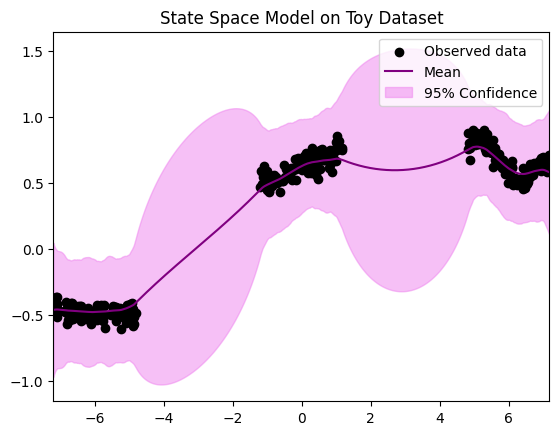

In [214]:
# plotGP defined in utils/functions.ipynb
plotGP_SS(x_train_toy, y_train_toy, ell=3, sigma=0.6, m0=0, v0=1, title="State Space Model on Toy Dataset")